# 1 Método de Brown

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Este método aún tiene lineas que se pude ahorrar

# Selección de datos

In [2]:
df=pd.read_csv("dataframe.csv",header=0)

In [3]:
df.index+=1
df.dtypes

t         int64
Y(t)    float64
dtype: object

In [4]:
df.columns = ['t','Y(t)']
df.index
df.tail()

,t,Y(t)
44,44,2.009
45,45,1.775
46,46,2.205
47,47,1.973
48,48,1.655


# Método

# Iteraciones del método

In [5]:
#Funcion que cálcula los valores necesarios para pronosticar menos p
def calcularValoresBrown(dataframe,alfa):
    df = dataframe.copy()
    #print(df.head())
    # Preparación de columnas
    df['A(t)'] = np.NaN
    df["A'(t)"] = np.NaN
    df['a(t)'] = np.NaN
    df['b(t)'] = np.NaN
    

    # Inicializar valores iniciales del método 
    Y1 = df.loc[1,'Y(t)'] 
    df.loc[1,'A(t)'] = Y1
    df.loc[1,"A'(t)"] = Y1
    df.loc[1,'a(t)'] = Y1
    df.loc[1,'b(t)'] = 0

    inicio = df['A(t)'].last_valid_index() + 1
    #print(df.head())
    for t in range(inicio, df.shape[0]+1):
        Yt = df.loc[t, 'Y(t)']

        # cálculo A(t)
        At_1 = df.loc[t-1, 'A(t)']
        At = alfa*Yt + (1-alfa)*At_1
        df.loc[t, 'A(t)'] = At

        # cálculo A'(t)
        At = df.loc[t, 'A(t)']
        Apt_1 = df.loc[t-1, "A'(t)"]
        Apt = alfa*At + (1-alfa)*Apt_1
        df.loc[t, "A'(t)"] = Apt

        #cálculo a(t) y b(t)
        At = df.loc[t, 'A(t)']
        Apt = df.loc[t, "A'(t)"]
        
        at = 2*At - Apt
        bt = alfa*(At - Apt)/(1-alfa)
        df.loc[t, 'a(t)'] = at
        df.loc[t, 'b(t)'] = bt
    
    return df




In [6]:
df=calcularValoresBrown(df,0.5)
df.head()

,t,Y(t),A(t),A'(t),a(t),b(t)
1,1,1.3660,1.366000,1.366000,1.366000,0.000000
2,2,1.4066,1.386300,1.376150,1.396450,0.010150
3,3,1.7025,1.544400,1.460275,1.628525,0.084125
4,4,1.6233,1.583850,1.522063,1.645637,0.061787
5,5,1.6970,1.640425,1.581244,1.699606,0.059181


In [7]:
#Funcion de pronostico
def pronosticoBrown(dataframe,numPronosticos=3):
    df = dataframe.copy()
    df['p'] = np.NaN
    df['F(t+p)'] = np.NaN
    inicio = df['Y(t)'].first_valid_index()+1 
    df.loc[inicio:df.shape[0],'p'] = 1 # inicia p en 1
    # ciclo de pronostico para los renglones con valor en Y(t) 
    for t in range(inicio,df.shape[0]): 
        at = df.loc[t, 'a(t)']
        bt = df.loc[t, 'b(t)']
        p = df.loc[t, 'p']

        Ftp = at + bt*p

        df.loc[t+p, 'F(t+p)'] = Ftp
    
    #Inicio de ciclo para pronosticar tiempos adelante
    at = df.loc[t+1, 'a(t)']
    bt = df.loc[t+1, 'b(t)']
    final=df.shape[0]

    for t in range(final, final+numPronosticos):
        Ftp = at + bt*p
        df.loc[t+1, 'F(t+p)'] = Ftp

        p+=1
        df.loc[t+1,'t']=t+1
        if p!=numPronosticos+1:
            df.loc[t+1,'p']=p

        
    return df

df=pronosticoBrown(df)
df.tail()




,t,Y(t),A(t),A'(t),a(t),b(t),p,F(t+p)
47,47.0,1.973,2.001469,1.980221,2.022717,0.021248,1.0,2.171869
48,48.0,1.655,1.828235,1.904228,1.752241,-0.075993,1.0,2.043965
49,49.0,NaN,NaN,NaN,NaN,NaN,2.0,1.676248
50,50.0,NaN,NaN,NaN,NaN,NaN,3.0,1.600255
51,51.0,NaN,NaN,NaN,NaN,NaN,NaN,1.524262


# Cálculo de errores

In [8]:
def calcularErrores(dataframe):
    df = dataframe.copy()
    df['e(t)'] = np.NaN
    df['|e(t)|'] = np.NaN
    df['e(t)^2'] = np.NaN
    df['|e(t)|/Y(t)'] = np.NaN

    inicio=df['F(t+p)'].first_valid_index()
    final=df['Y(t)'].last_valid_index()+1

    for i in range(inicio,final):
        Yt = df.loc[i]['Y(t)']
        pron = df.loc[i]['F(t+p)']
        et = Yt - pron
        et_abs = np.abs(et)

        df.loc[i, 'e(t)'] = et
        df.loc[i, '|e(t)|'] = et_abs
        df.loc[i, 'e(t)^2'] = et**2
        df.loc[i, '|e(t)|/Y(t)'] = et_abs/Yt

    errores = {
    'DAM': np.mean(df['|e(t)|']),
    'EMC': np.mean(df['e(t)^2']),
    'PEMA': np.mean(df['|e(t)|/Y(t)'])*100,
    }
    df_errores = pd.DataFrame(errores,index=['Errores:'])
    return df,df_errores

df,df_errores=calcularErrores(df)
print(df.tail())
print(df_errores.head())




       t   Y(t)      A(t)     A'(t)      a(t)      b(t)    p    F(t+p)  \
47  47.0  1.973  2.001469  1.980221  2.022717  0.021248  1.0  2.171869   
48  48.0  1.655  1.828235  1.904228  1.752241 -0.075993  1.0  2.043965   
49  49.0    NaN       NaN       NaN       NaN       NaN  2.0  1.676248   
50  50.0    NaN       NaN       NaN       NaN       NaN  3.0  1.600255   
51  51.0    NaN       NaN       NaN       NaN       NaN  NaN  1.524262   

        e(t)    |e(t)|    e(t)^2  |e(t)|/Y(t)  
47 -0.198869  0.198869  0.039549     0.100795  
48 -0.388965  0.388965  0.151294     0.235024  
49       NaN       NaN       NaN          NaN  
50       NaN       NaN       NaN          NaN  
51       NaN       NaN       NaN          NaN  
               DAM      EMC      PEMA
Errores:  0.161066  0.04145  8.902942


# Gráfica 

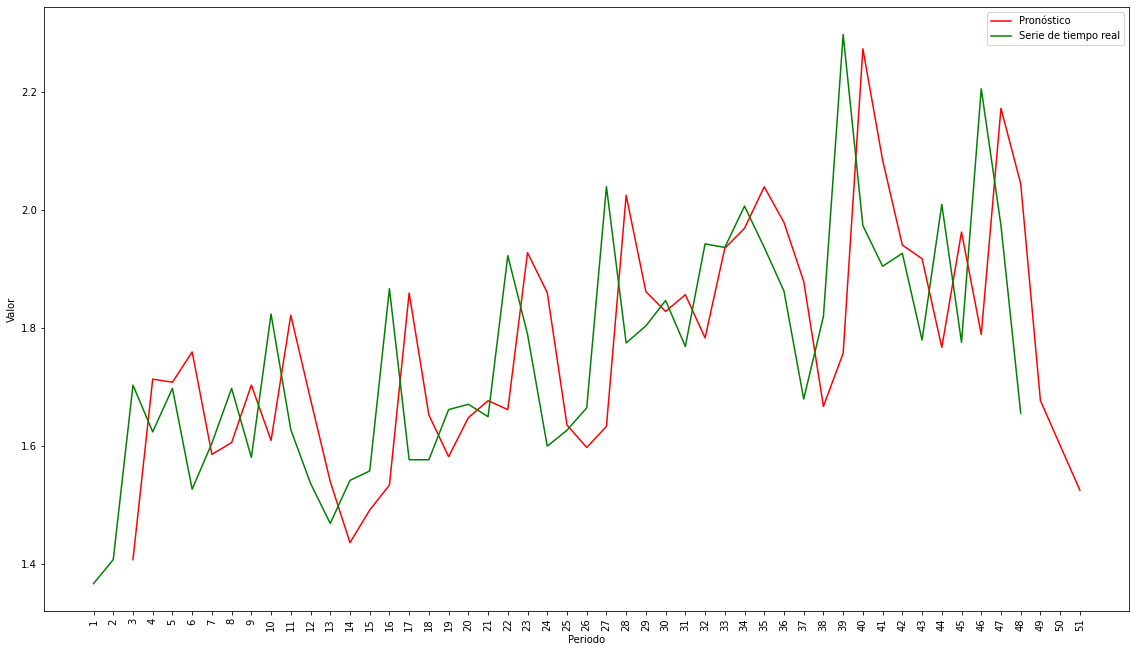

In [9]:
def pintarGrafico(dataframe,ancho=1400,alto=800):
    df=dataframe
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    plt.subplots(figsize=(ancho*px, alto*px))

    # Labels (etiquetas) de ejes x, y
    plt.ylabel('Valor')
    plt.xlabel('Periodo')

    # Puntos, pares ordenados que se calcularon como pronóstico
    plt.plot(
        df['t'], df['F(t+p)'], '-',
        label='Pronóstico',
        color='r'
    )

    # Puntos, pares ordenados que se proporcionaron como datos muestra
    plt.plot(
        df['t'], df['Y(t)'], '-',
        label='Serie de tiempo real',
        color='g'
    )
    
    plt.legend(loc='best')
    plt.xticks(df.index,rotation=90)
    plt.show()

pintarGrafico(df)

# Pronosticos en las series de tiempo del proyecto:

## Función de preparación y general de aplicación del método

In [10]:
def prepararDf(df):
    df.index+=1
    df.columns = ['periodo','Y(t)']
    df['t'] = df.index
    #print(df.head)

In [11]:
def aplicarMetodo(pathArchivocsv,alfa=0.5,numPronosticos=3):
    df=pd.read_csv(pathArchivocsv,header=0)
    prepararDf(df)
    df=calcularValoresBrown(df,alfa)
    df=pronosticoBrown(df,numPronosticos)
    df,df_errores=calcularErrores(df)
    return df,df_errores

# Método con la mejor PEMA

In [12]:
# función que busca todas la mejor alfa
# Computacionalmente es ineficiente pues es por fuerza bruta
def aplicarMetodoOptimizado(pathArchivocsv,numPronosticos=3):
    df=pd.read_csv(pathArchivocsv,header=0)
    prepararDf(df)
    PEMAmejor=100.0
    for alfa in np.arange(0.01,1,0.01):
        df2=calcularValoresBrown(df,alfa)
        df2=pronosticoBrown(df2,numPronosticos)
        df2,df_errores=calcularErrores(df2)
        PEMA = df_errores.loc['Errores:','PEMA']
        if PEMA<PEMAmejor:
            dfMejor=df2.copy()
            df_erroresMejor=df_errores.copy()
            PEMAmejor=PEMA
            alfaMejor=alfa
    df_erroresMejor['alfa']=[alfaMejor]        
    return dfMejor,df_erroresMejor

    periodo   Y(t)     t      A(t)     A'(t)      a(t)      b(t)    p  \
47     47.0  1.973  47.0  1.895506  1.788856  2.002156  0.010548  1.0   
48     48.0  1.655  48.0  1.873861  1.796507  1.951215  0.007650  1.0   
49      NaN    NaN  49.0       NaN       NaN       NaN       NaN  2.0   
50      NaN    NaN  50.0       NaN       NaN       NaN       NaN  3.0   
51      NaN    NaN  51.0       NaN       NaN       NaN       NaN  NaN   

      F(t+p)      e(t)    |e(t)|    e(t)^2  |e(t)|/Y(t)  
47  2.008208 -0.035208  0.035208  0.001240     0.017845  
48  2.012704 -0.357704  0.357704  0.127952     0.216135  
49  1.958865       NaN       NaN       NaN          NaN  
50  1.966515       NaN       NaN       NaN          NaN  
51  1.974166       NaN       NaN       NaN          NaN  
               DAM       EMC      PEMA  alfa
Errores:  0.121175  0.025784  6.759637  0.09


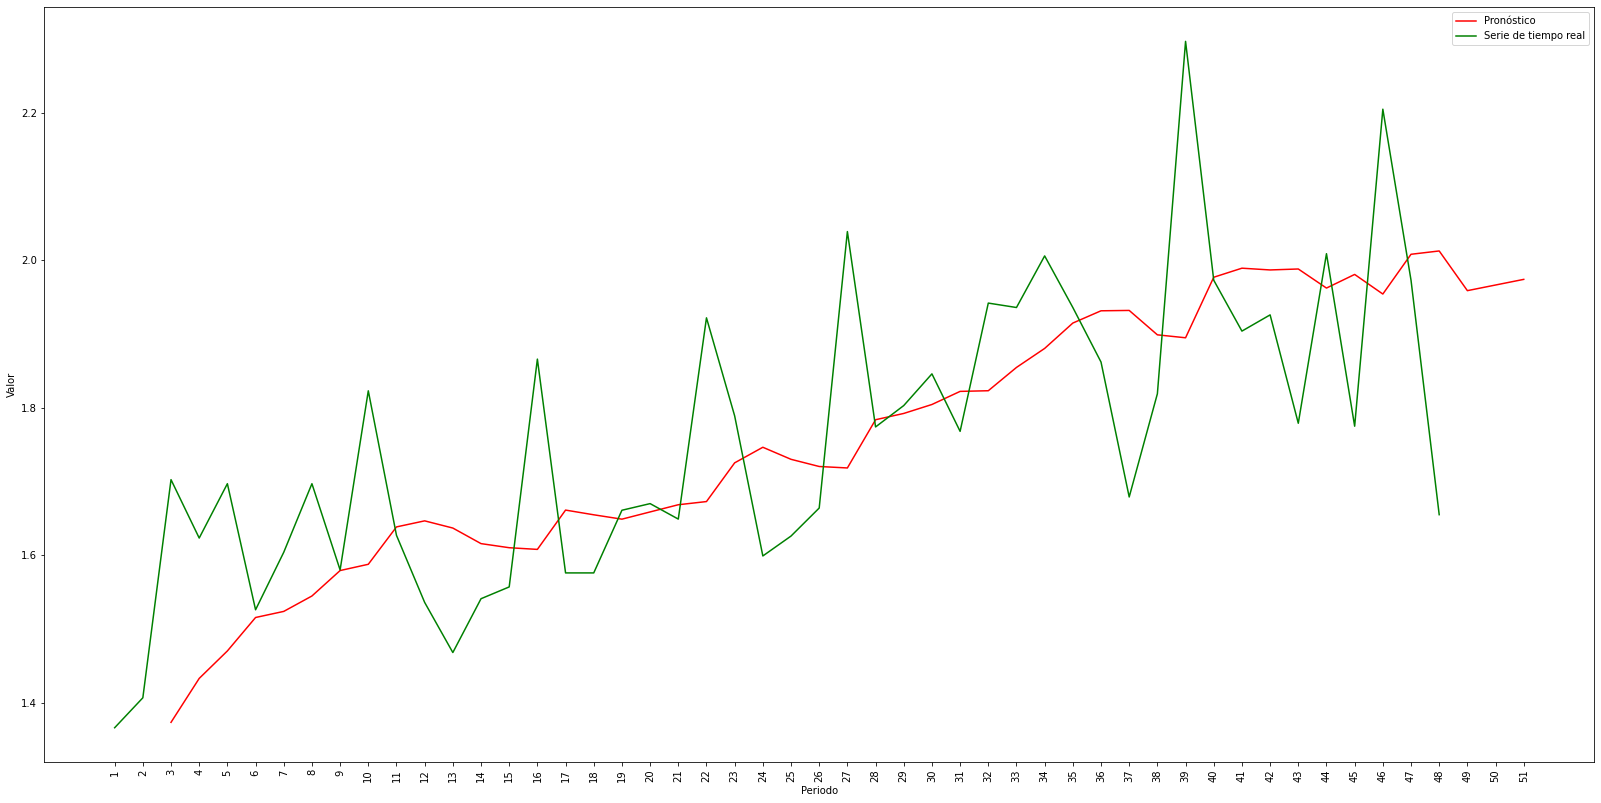

In [13]:
# Serie de ejemplo
dfserie,dfserie_errores = aplicarMetodoOptimizado("dataframe.csv")
print(dfserie.tail())
print(dfserie_errores)
pintarGrafico(dfserie,2000,1000)